### Обзор данных

In [5]:
# импортируем необходимые библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import warnings
from plotly import graph_objects as go
import plotly.express as px
import math as mth
!pip install -U kaleido

# задаем ширину столбцов датасета
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

In [7]:
# просмотр общей информации о датасете
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [8]:
# выводим первые 5 строк датасета 
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


#### Вывод
Исходный датафрейм состоит из 244126 строк, 4 столбцов. Тип данных - int64(3), object(1). Столбец EventTimestamp имеет ошибочный тип данных int64, не соответствующий дате и времени события. Наименование столбцов оформлено не в соответствии со стилем написания Snake case (змеиный регистр), поэтому требует переименования.

### Предобработка данных

In [9]:
# переименование столбцов
logs.rename(columns = {'EventName':'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_time', 'ExpId':'group'}\
                , inplace = True )

In [10]:
# меняем тип данных в столбце logs['event_time']
logs['event_time'] = pd.to_datetime(logs['event_time'], unit='s')

In [11]:
# создаем столбец даты событий
logs['event_date'] = pd.to_datetime(logs['event_time']).dt.date

In [12]:
# вводим переменную для исходного датасета
first_log = logs.copy()

In [13]:
# анализируем количество дубликатов по сумме ключевых параметров
logs.duplicated(subset=['event_name', 'user_id', 'event_time', 'group', 'event_date']).sum()

413

In [14]:
# удаляем дубликаты по подмножеству
logs = logs.drop_duplicates(subset=['event_name', 'user_id', 'event_time', 'group', 'event_date'], keep='first')

In [15]:
# проверяем наличие пропущенных значений в датасете
logs.isna().sum()

event_name    0
user_id       0
event_time    0
group         0
event_date    0
dtype: int64

In [16]:
# проверяем общую информацию после обработки данных
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   event_date  243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [17]:
# проверяем первые 5 строк датасета после обработки данных
logs.head()

,event_name,user_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


#### Вывод

В процессе предобработки данных сделано:

1. Написание столбцов переименовано и приведено в соответствие со стилем Snake case;
2. Исправлен тип данных в столбце logs['event_time'] на datetime64;
3. Добавлен столбец event_date с датой события;
4. Найдены и удалены 413 дубликатов;
5. Датасет не имеет пропущенных значений.

Таким образом, в анализируемом датасете 243713 строк, 5 столбцов. Тип данных - datetime64(1), int64(2), object(2).

### Изучение данных

In [18]:
# определяем количество событий в логе
print('Всего количество событий в датасете составляет', logs['event_name'].count())

Всего количество событий в датасете составляет 243713


In [19]:
# определяем количество уникальных событий в логе
print('Количество уникальных событий в датасете составляет', logs['event_name'].nunique())

Количество уникальных событий в датасете составляет 5


In [20]:
# считаем количество уникальных пользователей
print('Количество уникальных пользователей в датасете составляет', logs['user_id'].nunique())

Количество уникальных пользователей в датасете составляет 7551


In [21]:
# группируем количество событий на 1 пользователя
avg = logs.groupby('user_id')['event_name'].count()

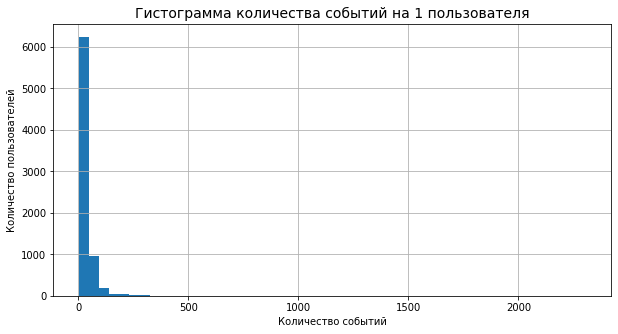

In [22]:
# строим график количества событий на 1 пользователя
avg.hist(bins=5*10, figsize=(10, 5))
plt.title('Гистограмма количества событий на 1 пользователя', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=10)
plt.xlabel('Количество событий', fontsize=10)
plt.show()

In [23]:
# отобразим статистическую сводку по количеству событий на 1 пользователя
avg.describe().round(1)

count    7551.0
mean       32.3
std        65.2
min         1.0
25%         9.0
50%        20.0
75%        37.0
max      2307.0
Name: event_name, dtype: float64

In [24]:
print('90, 95 и 99 перцентили количества событий на одного пользователя соответственно:', 
      np.percentile(avg, [90, 95, 99]))

90, 95 и 99 перцентили количества событий на одного пользователя соответственно: [ 64.   89.  200.5]


#### Вывод
1. В результате предобработки данных в датасете содержатся 243713 событий, в т.ч. 5 уникальных, и 7551 уникальный пользователь мобильного приложения.
2. Исходя из статистической сводки среднее количество событий, приходящееся на 1 пользователя, составляет 20 единиц, в связи с наличием в данных аномальных значений (максимальное значение - 2307 событий на 1 пользователя, 1% пользователей совершает более 200 действий) предлагается средним принять медианное количество событий на 1 посетителя, равное 32 единицам. Учитывая техническое задание на дальнейшее исследование, не включающее расчет метрик, зависящих от количества событий на 1 пользователя, предлагается аномальные значения оставить в датасете.

In [25]:
# определяем минимальную и максимальную даты событий
print('Минимальная дата событий -', logs['event_time'].min())
print('Максимальная дата событий -', logs['event_time'].max())

Минимальная дата событий - 2019-07-25 04:43:36
Максимальная дата событий - 2019-08-07 21:15:17


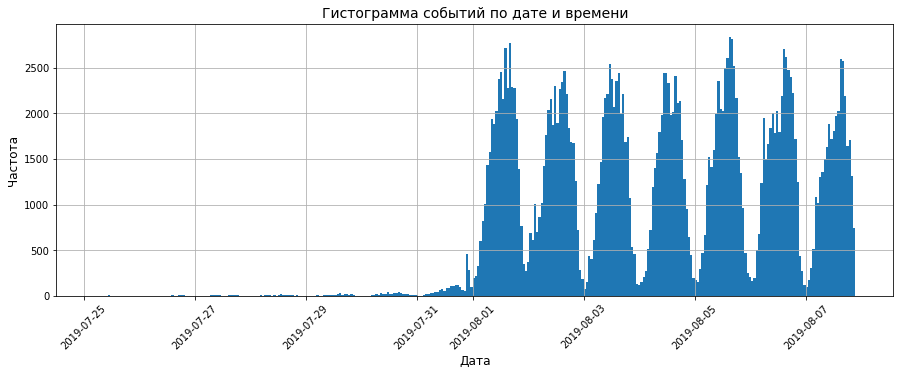

In [26]:
# строим график событий по дате и времени
logs['event_time'].hist(bins=14*24, figsize=(15, 5))
plt.title('Гистограмма событий по дате и времени', fontsize=14)
plt.ylabel('Частота', fontsize=12)
plt.tick_params(labelsize=10)
plt.xlabel('Дата', fontsize=12)
plt.xticks(rotation=45)
plt.show()

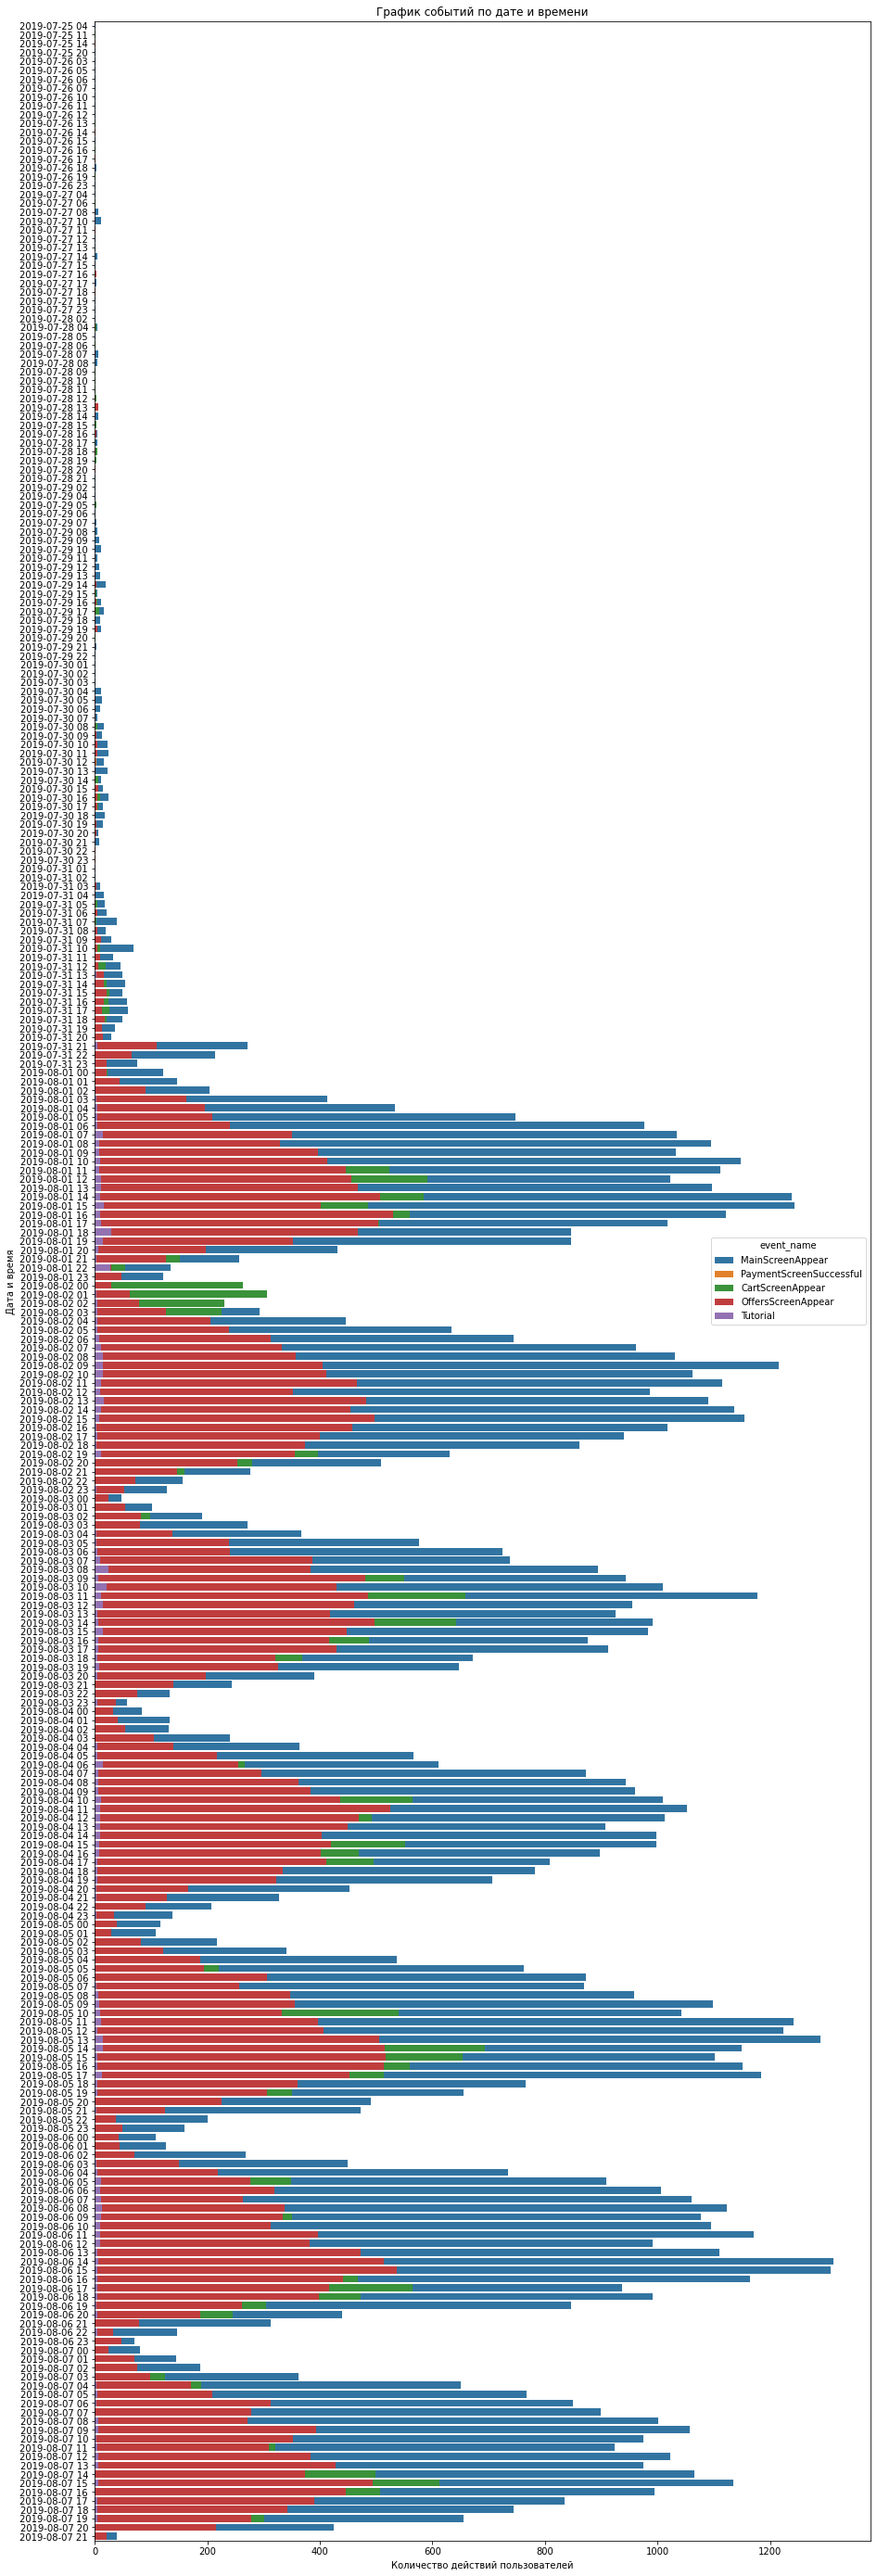

In [27]:
# строим детализированный по времени график в разрезе событий
plt.figure(figsize=(15, 50))
ax = sns.countplot(y=logs['event_time'].dt.strftime('%Y-%m-%d %H'), hue='event_name', data=logs, dodge=False)
ax.set_title('График событий по дате и времени')
plt.xlabel('Количество действий пользователей')
plt.ylabel('Дата и время')
plt.show()

In [28]:
# обновляем датасет с учетом исключения данных за период до 31 июля 2019 года 21.00
logs = logs['2019-07-31 21:00' < logs['event_time']]

In [29]:
# вводим переменную откорректированного датасета
filter_log = logs.copy()

In [30]:
# определяем минимальную и максимальную даты событий после корректировки 
print('Минимальная дата событий после корректировки -', logs['event_time'].min())
print('Максимальная дата событий после корректировки -', logs['event_time'].max())

Минимальная дата событий после корректировки - 2019-07-31 21:00:57
Максимальная дата событий после корректировки - 2019-08-07 21:15:17


In [31]:
# определяем количество событий после корректировки 
print('Количество событий после корректировки -', logs['event_name'].count())

Количество событий после корректировки - 241724


In [32]:
# определяем количество пользователей после корректировки 
print('Количество пользователей после корректировки -',logs['user_id'].nunique())

Количество пользователей после корректировки - 7538


In [33]:
# проверяем процент потерянных событий и пользователей после корректировки, включая удаление дубликатов
print('Потери в количестве событий в результате корректировки -', len(first_log) - len(filter_log))
print(f'Доля потерянных событий в результате корректировки -', '{0:.2%}'.format((len(first_log) - len(filter_log))\
/len(first_log)))
print('Потери в количестве уникальных пользователей в результате корректировки -', first_log['user_id']\
.nunique() - filter_log['user_id'].nunique())
print(f'Доля потерянных пользователей в результате корректировки -', '{0:.2%}'.format((first_log['user_id']\
.nunique() - filter_log['user_id'].nunique())/first_log['user_id'].nunique()))

Потери в количестве событий в результате корректировки - 2402
Доля потерянных событий в результате корректировки - 0.98%
Потери в количестве уникальных пользователей в результате корректировки - 13
Доля потерянных пользователей в результате корректировки - 0.17%


In [34]:
# присваеваем буквенные обозначения группам эксперимента
def type_group(row):
    if row['group'] == 246:
        return 'A1'
    if row['group'] == 247:
        return 'A2'
    if row['group'] == 248:
        return 'B'
    else:
        return 'other groups'

logs['type_group'] = logs.apply(type_group, axis=1)

In [35]:
# считаем количество уникальных пользователей по группам эксперимента
logs.groupby('type_group')['user_id'].agg(['nunique']).sort_values(by='nunique', ascending=False)

,nunique
type_group,
B,2537
A2,2517
A1,2484


In [36]:
# создаем множетства пользователей для групп А1, A2 и В
user_idA1 = set(logs[(logs['type_group'] == 'A1')]['user_id'])
user_idA2 = set(logs[(logs['type_group'] == 'A2')]['user_id'])
user_idB = set(logs[(logs['type_group'] == 'B')]['user_id'])

# проверяем пересечение элементов во множествах пользователей групп А1, A2 и В
intersect_users = set.intersection(user_idA1, user_idA2, user_idB)
intersect_users

set()

#### Вывод

1. Исходный датасет имеет временной интервал с 25 июля 2019 года 04:43:36 по 07 августа 2019 года 21:15:17. Графики, построенные на основе данных о дате, времени и количестве событий, демонстрируют неполные и незначительные данные до 31 июля 2019 года 21:00, поэтому проведена корректировка датасета, в результате данные в период с 25 июля 2019 года до 31 июля 2019 года 20:00 включительно удалены.
2. Откорректированный датасет состоит из 241724 событий и 7538 уникальных пользователей мобильного приложения.
3. В результате корректировки временного периода, а также удаления дубликатов на этапе предобработки, потери в данных составили:
 - потери в количестве событий в результате корректировки - 2402 единицы;
 - доля потерянных событий в результате корректировки - 0.98%;
 - потери в количестве уникальных пользователей в результате корректировки - 13 человек;
 - доля потерянных пользователей в результате корректировки - 0.17%.
4. Создан столбец type_group, в котором группам эксперимента присвоены следующие буквенные обозначения: А1 - 246 контрольная группа, А2 - 247 контрольная группа, В - 248 экспериментальная группа.
5. В результате подсчета уникальных пользователей в каждой группе эксперимента выявлено, что сегменты сопоставимы по размеру, распределены в порядке убывания В(2537), А1(2517), А2(2484 человека). Пересечение пользователей в группах не выявлено.

### Анализ воронки событий

In [37]:
# формируем таблицу в разрезе событий с подсчетом количества событий и пользователей
logs.groupby('event_name')['user_id'].agg(['count', 'nunique']).sort_values(by='count', ascending=False)

,count,nunique
event_name,,
MainScreenAppear,117889,7423
OffersScreenAppear,46531,4597
CartScreenAppear,42343,3736
PaymentScreenSuccessful,33951,3540
Tutorial,1010,843


In [38]:
#подсчет числа пользователей, совершивших каждое событие
users_count = logs.groupby('event_name')['user_id'].nunique().reset_index()
users_count.columns = ['event_name', 'users_count']

#сортировка событий по числу пользователей
sorted_events = users_count.sort_values('users_count', ascending=False)

#подсчет доли пользователей, совершивших каждое событие, от общего количества пользователей
users_percentage = round((sorted_events['users_count'] / logs['user_id'].nunique()) * 100, 1)
sorted_events['users_percentage'] = users_percentage

sorted_events

,event_name,users_count,users_percentage
1,MainScreenAppear,7423,98.5
2,OffersScreenAppear,4597,61.0
0,CartScreenAppear,3736,49.6
3,PaymentScreenSuccessful,3540,47.0
4,Tutorial,843,11.2


Последовательность событий в процессе использования мобильного приложения выглядит следующим образом:
1.	MainScreenAppear - Переход на главный экран
2.	OffersScreenAppear - Переход на страницу товара
3.	CartScreenAppear - Переход в корзину
4.	PaymentScreenSuccessful - Успешная оплата.

В датасете содержится еще один вид события Tutorial - обучающая инструкция, которой воспользовались 11% посетителей, предполагается, что данный этап является необязательным, прохождение на усмотрение пользователей.

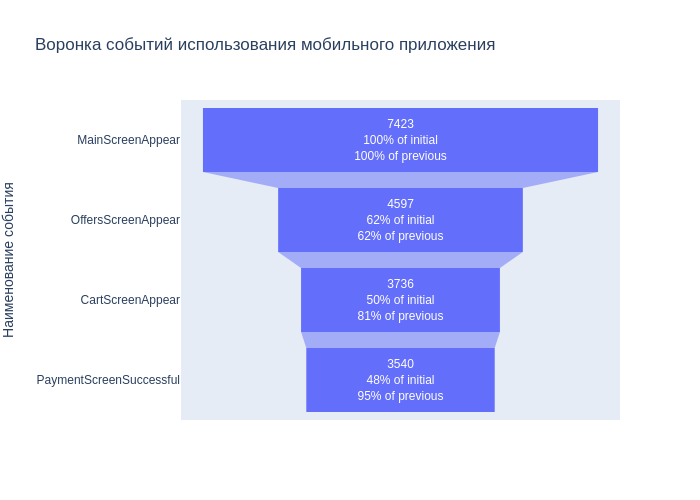

In [39]:
# отобразим воронку событий
fig = go.Figure(go.Funnel(
    y = sorted_events[sorted_events['event_name'] != 'Tutorial']['event_name'],
    x = sorted_events['users_count'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous"))
fig.update_layout(title = 'Воронка событий использования мобильного приложения', yaxis_title = 'Наименование события')

fig.show('png')

In [40]:
# подсчет доли пользователей, переходящих на следующий этап воронки событий
users_count = logs[logs['event_name'] != 'Tutorial'].groupby('event_name')['user_id']\
.agg(['nunique']).sort_values(by='nunique', ascending=False)
shift = users_count.shift(periods=1, axis=0)
sh = round(users_count/shift*100, 1)
sh

,nunique
event_name,
MainScreenAppear,NaN
OffersScreenAppear,61.9
CartScreenAppear,81.3
PaymentScreenSuccessful,94.8


In [41]:
# подсчет доли пользователей, дошедших до оплаты
first_event = logs[logs['event_name'] == 'MainScreenAppear']['user_id'].nunique()
last_event = logs[logs['event_name'] == 'PaymentScreenSuccessful']['user_id'].nunique()
share_paying = round(last_event/first_event*100, 1)
print('Процент пользователей, завершивших покупку -', share_paying)

Процент пользователей, завершивших покупку - 47.7


In [42]:
#подсчет доли пользователей, совершивших каждое событие в группе A1
group_logs = logs[logs['event_name'] != 'Tutorial']
A1 = group_logs[group_logs['type_group'] == 'A1'].groupby('event_name').agg({'user_id':'nunique'})\
.rename(columns=({'user_id':'amount'})).sort_values(by='amount', ascending=False)
A1['step'] = round(A1['amount']/2450*100,1)
A1 = A1.reset_index()
A1

,event_name,amount,step
0,MainScreenAppear,2450,100.0
1,OffersScreenAppear,1542,62.9
2,CartScreenAppear,1266,51.7
3,PaymentScreenSuccessful,1200,49.0


In [43]:
#подсчет доли пользователей, совершивших каждое событие в группе A2
A2 = group_logs[group_logs['type_group'] == 'A2'].groupby('event_name').agg({'user_id':'nunique'})\
.rename(columns=({'user_id':'amount'})).sort_values(by='amount', ascending=False)
A2['step'] = round(A2['amount']/2479*100,2)
A2 = A2.reset_index()
A2

,event_name,amount,step
0,MainScreenAppear,2479,100.00
1,OffersScreenAppear,1524,61.48
2,CartScreenAppear,1239,49.98
3,PaymentScreenSuccessful,1158,46.71


In [44]:
#подсчет доли пользователей, совершивших каждое событие в группе B
B = group_logs[group_logs['type_group'] == 'B'].groupby('event_name').agg({'user_id':'nunique'})\
.rename(columns=({'user_id':'amount'})).sort_values(by='amount', ascending=False)
B['step'] = round(B['amount']/2494*100,2)
B = B.reset_index()
B

,event_name,amount,step
0,MainScreenAppear,2494,100.00
1,OffersScreenAppear,1531,61.39
2,CartScreenAppear,1231,49.36
3,PaymentScreenSuccessful,1182,47.39


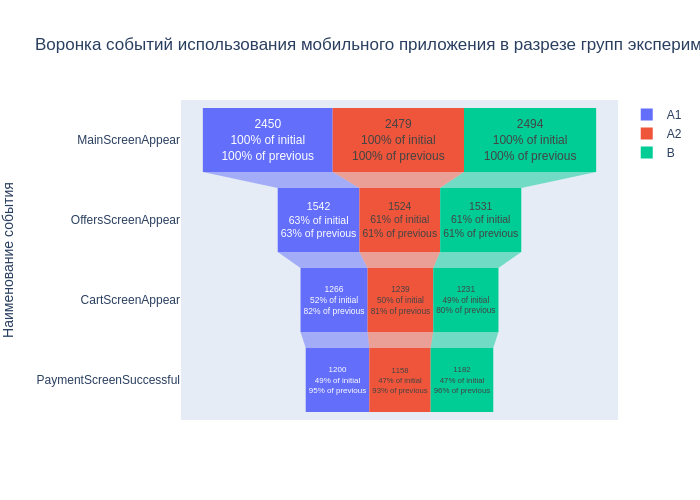

In [45]:
# построим воронку событий для каждой группы
fig = go.Figure()
fig.update_layout(title = 'Воронка событий использования мобильного приложения в разрезе групп эксперимента',\
                  yaxis_title = 'Наименование события')

fig.add_trace(go.Funnel(
    name = 'A1',
    y = A1['event_name'],
    x = A1['amount'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous"))

fig.add_trace(go.Funnel(
    name = 'A2',
    orientation = "h",
    y = A2['event_name'],
    x = A2['amount'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = B['event_name'],
    x = B['amount'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous"))

fig.show('png')

#### Вывод
По результатам оценки воронки событий:
1. Распространенность событий выглядит следующим образом в порядке убывания:
- переход на главный экран совершили 7423 человек (98,5% от общего количества пользователей), всего событий 117889 единиц;
- переход на страницу товара совершили 4597 человек (61% от общего количества пользователей), всего событий 46531	единиц;
- переход в корзину совершили 3736 человек (49,6% от общего количества пользователей), всего событий 42343	единиц;	
- успешную оплату совершили 3540 человек (47% от общего количества пользователей), всего событий 33951 единиц;	
- с обучающей инструкцией ознакомились 843 человека (11,2% от общего количества пользователей), всего событий 1010 единиц.
2. Логичекая последовательность воронки событий: переход на главный экран - переход на страницу товара - переход в корзину - успешная оплата. Этап по ознакомлению с обучающей инструкцией рекомендательным.
3. Пошаговая доля пользователей: переход на главный экран (100%) - переход на страницу товара (61,9%) - переход в корзину (81,3%) - успешная оплата (94,8%). Наибольшее количество пользователей теряется на этапе перехода с главного экрана на страницу товара (38,1%).
4. Доля пользователей, завершивших покупку (от главного экрана до успешной оплаты) - 47,7%.
5. График воронки в разрезе экспериментальных групп демонстрирует идентичное распределение пользователей по этапам событий:
- переход на главный экран (100%);
- переход на страницу товара (~60% от пользователей, совершивших переход на главный экран);
- переход в корзину (~50% от пользователей, совершивших переход на главный экран, и ~81% от пользователей, совершивших переход на страницу товара);
- успешная оплата (~48% от пользователей, совершивших переход на главный экран, и ~95% от пользователей, совершивших переход в корзину).

### А/А/В-тест

In [46]:
# посчитаем количество пользователей в каждой экспериментальной группе
users_bygroup = logs.groupby('type_group')['user_id'].nunique()
#создадим столбец с суммой пользователей групп А1 и А2
users_bygroup['A1+A2'] = users_bygroup['A1'] + users_bygroup['A2']
users_bygroup

type_group
A1       2484
A2       2517
B        2537
A1+A2    5001
Name: user_id, dtype: int64

In [47]:
# посчитаем количество пользователей, совершившие действие, по группам
event_group_test = logs.pivot_table(
    index='event_name', 
    columns='type_group', 
    values='user_id',
    aggfunc='nunique').sort_values(by='A1', ascending=False)

event_group_test = event_group_test.reset_index()
event_group_test['A1+A2'] = event_group_test['A1'] + event_group_test['A2']
event_group_test['all'] = event_group_test['A1+A2'] + event_group_test['B']

# посчитаем долю, совершивших действие, от общего количества пользователей по группам
event_group_test['part_A1'] = (event_group_test['A1'] / users_bygroup['A1'] * 100).round(1)
event_group_test['part_A2'] = (event_group_test['A2'] / users_bygroup['A2'] * 100).round(1)
event_group_test['part_B'] = (event_group_test['B'] / users_bygroup['B'] * 100).round(1)
event_group_test['part_A1+A2'] = ((event_group_test['A1'] + event_group_test['A2']) / \
(users_bygroup['A1'] + users_bygroup['A2']) * 100).round(1)
event_group_test


type_group,event_name,A1,A2,B,A1+A2,all,part_A1,part_A2,part_B,part_A1+A2
0,MainScreenAppear,2450,2479,2494,4929,7423,98.6,98.5,98.3,98.6
1,OffersScreenAppear,1542,1524,1531,3066,4597,62.1,60.5,60.3,61.3
2,CartScreenAppear,1266,1239,1231,2505,3736,51.0,49.2,48.5,50.1
3,PaymentScreenSuccessful,1200,1158,1182,2358,3540,48.3,46.0,46.6,47.2
4,Tutorial,278,284,281,562,843,11.2,11.3,11.1,11.2


In [48]:
# создадим функцию, для проведения z-теста
def z_test(group1, group2, alpha):
    for i in event_group_test.index:
        p1 = event_group_test[group1][i] / users_bygroup[group1]
        # пропорция успехов во второй группе:
        p2 = event_group_test[group2][i] / users_bygroup[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((event_group_test[group1][i] + event_group_test[group2][i]) / 
                      (users_bygroup[group1] + users_bygroup[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_bygroup[group1] + 1/users_bygroup[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = stats.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(event_group_test['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

В целях проведения А/А/В-тестирования сформулированы гипотезы:
- Н0 - между долями пользователей значимой разницы нет;
- Н1 - между долями пользователей есть значимая разница.

Выбран уровень статистической значимости - 0,05.

In [49]:
# проверяем контрольные группы
z_test("A1", "A2", 0.05)

MainScreenAppear p-значение: 0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение: 0.9182790262812368
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [50]:
# проверяем контрольную группу А1 и экспериментальную группу В
z_test("A1", "B", 0.05)

MainScreenAppear p-значение: 0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение: 0.8964489622133207
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [51]:
# проверяем контрольную группу А2 и экспериментальную группу В
z_test("A2", "B", 0.05)

MainScreenAppear p-значение: 0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение: 0.8151967015119994
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [52]:
# проверяем сумму контрольных групп А1+А2 и экспериментальную группу В
z_test("A1+A2", "B", 0.05)

MainScreenAppear p-значение: 0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение: 0.8333049080125807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [53]:
# считаем количество проверок статистических гипотез 
count_stat_hypo = len(users_bygroup) * len(logs['event_name'].unique())
print('Было сделано проверок статистических гипотез:', count_stat_hypo)

Было сделано проверок статистических гипотез: 20


Поскольку аудитория исследования разбита более чем на две подгруппы, вероятность получить ошибку первого рода при эксперименте нарастает экспоненциально. С целью контроля групповой вероятности ошибки рассчитаем скорректированный уровень статистической значимости методом Шидака и проведем повторные тесты с учетом скорректированного уровеня статистической значимости.

In [54]:
# рассчитаем скорректированный уровень статистической значимости методом Шидака
shidak_alpha = 1 - (1 - 0.05)**(1 / count_stat_hypo)
print('Скорректированный уровень статистической значимости:', shidak_alpha)

Скорректированный уровень статистической значимости: 0.0025613787765302876


In [55]:
z_test("A1", "A2", shidak_alpha)

MainScreenAppear p-значение: 0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение: 0.9182790262812368
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [56]:
z_test("A1", "B", shidak_alpha)

MainScreenAppear p-значение: 0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение: 0.8964489622133207
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [57]:
z_test("A2", "B", shidak_alpha)

MainScreenAppear p-значение: 0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение: 0.8151967015119994
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [58]:
z_test("A1+A2", "B", shidak_alpha)

MainScreenAppear p-значение: 0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение: 0.8333049080125807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### Вывод
1. Количество пользователей по экспериментальным группам:
- A1 - 2484 челловек;
- A2 - 2517 человек;
- B - 2537 человек;
- A1+A2 - 5001 человек.
2. Наиболее популярное событие в датасете - переход на главную страницу (MainScreenAppear), в каждой экспериментальной группе его совершили более 98% от общего числа пользователей по группам:
- A1 - 2450 челловек;
- A2 - 2479 человек;
- B - 2494 человека;
- A1+A2 - 4929 человек.
3. По всем остальным событиям процентное соотношение совершивших действие к общему количеству пользователей по группам тождественно.
4. В ходе А/А/В-теста были сформулированы гипотезы:
- Н0 - между долями пользователей значимой разницы нет;
- Н1 - между долями пользователей есть значимая разница.
5. При проверке статистических гипотез был выбран уровень статистической значимости 0,05.
6. В ходе 20 проверок статистических гипотез по 4 группам (А1, А2, В, А1+А2) в разрезе 5 событий был получен результат 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'.
6. В целях исключения вероятности ошибки первого рода при проведении множественного теста рассчитан скорректированный уровень статистической значимости методом Шидака.
7. В результате проведенных тестов с использованием скорректированного уровеня статистической значимости подтвердилась Н0 - между долями пользователей значимой разницы нет.

### Общий вывод
1. В анализируемом датасете содержится информация о 241724 событиях и 7538 уникальных пользователях мобильного приложения по продаже продуктов питания.
2. Наблюдаемый период времени - с 31 июля 2019 года 21:00 по 07 августа 2019 года 21:15:17.
3. Воронка событий состоит из 4 этапов:
- MainScreenAppear - переход на главный экран;
- OffersScreenAppear - переход на страницу товара;
- CartScreenAppear - переход в корзину;
- PaymentScreenSuccessful - успешная оплата.
- Дополнительно в датасет включено события Tutorial - обучающая инструкция.
4. На главный экран переходят более 98% от общего количества пользователей приложения.
5. До покупки товара доходят порядка 48% пользователей, зашедших на главный экран.
6. Наибольшие потери пользователей наблюдаются при переходе с главного экрана на страницу товара - около 40%.
7. В среднем около 95% пользователей, перешедших в корзину, осуществляют оплату.
8. Тесты проведены по 4 группам -  (А1, А2, А1+А2 - контрольные группы, В - экспериментальная группа с измененным шрифтом).
9. В ходе проверок с уровенем статистической значимости 0,05 и скорректированным уровнем статистической значимости методом Шидака выявлено, что значимой разницы между долями пользователей во всех комбинациях групп (А/А/В-тест) нет.
10. Изменение шрифта во всем приложении нецелесообразно.
11. В связи с соотношением количества посетителей главной страницы приложения к общему количеству пользователей в размере 98,5% рекомендуется обращение к техническим специалистам для анализа возможных функциональных проблем (сбой, ошибки авторизации и т.д.).